# Solving logic puzzles with monkeys

In this notebook, we solve two logic puzzles using the `monkeys` diagnosis tool. While this constitutes a nonstandard use of the diagnostics module, it does demonstrate the flexibility of the framework. 

## Die Hard

The first logic puzzle is from Die Hard 3: given two jugs -- one three gallons, one five -- how can you measure 4 gallons exactly?

Approaches to this problem have previously been demonstrated using [TLA+](https://github.com/tlaplus/Examples/blob/master/specifications/DieHard/DieHard.tla) and [Hypothesis](http://hypothesis.works/articles/how-not-to-die-hard-with-hypothesis/), both of which are worth looking at as excellent examples for understanding those respective tools.

For our `monkeys` solution, we will first describe various operations on a joint bucket state. In constrast to the TLA+ and Hypothesis examples, in this version, we will also introduce a time limit of 10 iterations, much like in the [Die Hard scene](https://www.youtube.com/watch?v=6cAbgAaEOVE).

In [1]:
from monkeys import *
from collections import namedtuple

BucketState = namedtuple('BucketState', 'small big time_remaining')

@params()
@rtype(BucketState)
def begin():
    return BucketState(small=0, big=0, time_remaining=10)

@params()
@rtype('Action')
def empty():
    return 'empty'

@params()
@rtype('Action')
def fill():
    return 'fill'

def ensure_time_remaining(buckets):
    assert buckets.time_remaining > 0, "Boom!"
    return buckets

@params(BucketState, 'Action')
@rtype(BucketState)
def small(buckets, action):
    return ensure_time_remaining(
        BucketState(
            small=3 if action == 'fill' else 0, 
            big=buckets.big,
            time_remaining=buckets.time_remaining - 1
        )
    )

@params(BucketState, 'Action')
@rtype(BucketState)
def big(buckets, action):
    return ensure_time_remaining(
        BucketState(
            small=buckets.small, 
            big=5 if action == 'fill' else 0,
            time_remaining=buckets.time_remaining - 1
        )
    )

@params(BucketState)
@rtype(BucketState)
def pour_small_into_big(buckets):
    new_big = min(5, buckets.big + buckets.small)
    return ensure_time_remaining(
        BucketState(
            small=buckets.small - (new_big - buckets.big),
            big=new_big,
            time_remaining=buckets.time_remaining - 1
        )
    )

@params(BucketState)
@rtype(BucketState)
def pour_big_into_small(buckets):
    new_small = min(3, buckets.big + buckets.small)
    return ensure_time_remaining(
        BucketState(
            small=new_small,
            big=buckets.big - (new_small - buckets.small),
            time_remaining=buckets.time_remaining - 1
        )
    )

Notice that all operations on `BucketState` potentially raise an exception, should time have run out. In searching for a solution to the problem, we'll be looking to find violations of a test asserting that the "big" bucket does _not_ contain four gallons of water:

In [2]:
from monkeys.tools.diagnostics import diagnose

def ensure_unsolved(buckets):
    assert buckets.big != 4, "Problem solved"

diagnosis = diagnose(BucketState, test=ensure_unsolved, sample_size=100000)
diagnosis.show_report()

Discovered 2 distinct exceptions.
Reproducing exceptions...
Done.
AssertionError('Problem solved',):
    0.25 | (big) -> pour_big_into_small
    0.16 | (pour_big_into_small, empty) -> small
    0.12 | (begin, fill) -> big
AssertionError('Boom!',):
    1.20 | (small) -> pour_big_into_small
    0.90 | (big) -> pour_big_into_small
    0.89 | (pour_big_into_small, empty) -> small


Having found two exceptions that can occur when generating programs in this scenario, we can visualize the error we're interested in (in which the problem has been solved). Note that the final step in the solution is displayed at the top of the tree, with the start state (`begin`) at the very bottom:

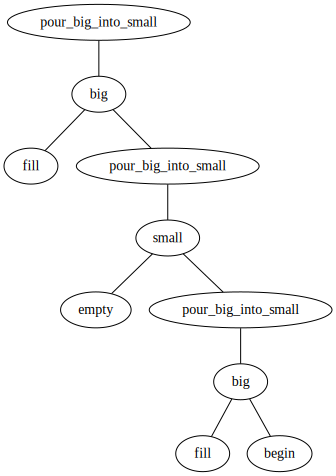

In [3]:
from monkeys.tools.display import node_graph

node_graph(
    diagnosis.minimal_reproductions[
        repr(AssertionError('Problem solved'))
    ]
)

## The fox, the hen, and the grain

Our second logic puzzle is [well-known](https://en.wikipedia.org/wiki/Fox,_goose_and_bag_of_beans_puzzle): a farmer is trying to cross a river with a fox, a hen, and a bag of grain. The farmer's boat can carry only one of these items (along with the farmer) at a time. As long as the farmer is supervising, there are no issues. However, if the farmer leaves the fox alone with the hen, or the hen alone with the grain, the former will eat the latter. The puzzle is to show how the farmer can cross all items over from the left to the right bank of the river without this occurring.

We again describe the scenario in terms of `monkeys` functions, checking after each operation that nothing has been eaten:

In [4]:
RiverState = namedtuple('RiverState', 'left_bank right_bank')

@params()
@rtype(RiverState)
def start():
    return RiverState(
        left_bank={'farmer', 'fox', 'hen', 'grain'},
        right_bank=set()
    )

@params()
@rtype('Item')
def fox():
    return 'fox'

@params()
@rtype('Item')
def hen():
    return 'hen'

@params()
@rtype('Item')
def grain():
    return 'grain'

def ensure_nothing_eaten(bank):
    assert not ('fox' in bank and 'hen' in bank), "The fox ate the hen."
    assert not ('hen' in bank and 'grain' in bank), "The hen ate the grain."

@params(RiverState)
@rtype(RiverState)
def cross(river):
    if 'farmer' in river.left_bank:
        leaving_from, arriving_at = river.left_bank, river.right_bank
    else:
        leaving_from, arriving_at = river.right_bank, river.left_bank
    leaving_from.remove('farmer')
    arriving_at.add('farmer')
    ensure_nothing_eaten(leaving_from)
    return river

@params(RiverState, 'Item')
@rtype(RiverState)
def try_cross_moving(river, item):
    if 'farmer' in river.left_bank:
        leaving_from, arriving_at = river.left_bank, river.right_bank
    else:
        leaving_from, arriving_at = river.right_bank, river.left_bank
    leaving_from.remove('farmer')
    if item in leaving_from:
        leaving_from.remove(item)
        arriving_at.add(item)
    arriving_at.add('farmer')
    ensure_nothing_eaten(leaving_from)
    return river

As with the Die Hard example, we can now search for combinations of these functions which violate an assumption that the problem is unsolved (that is, that the farmer, fox, hen, and grain are not all together on the right side of the river).

In [5]:
from monkeys.tools.diagnostics import diagnose

def ensure_unsolved(river):
    assert not all(
        item in river.right_bank
        for item in ('farmer', 'fox', 'hen', 'grain')
    ), "Problem solved"

diagnosis = diagnose(RiverState, test=ensure_unsolved, sample_size=100000)
diagnosis.show_report()

Discovered 3 distinct exceptions.
Reproducing exceptions...
Done.
AssertionError('The fox ate the hen.',):
    3.76 | (start) -> cross
    2.06 | (try_cross_moving) -> cross
    1.72 | (start, grain) -> try_cross_moving
AssertionError('Problem solved',):
    0.00 | (try_cross_moving, grain) -> try_cross_moving
    0.00 | (try_cross_moving) -> cross
    0.00 | (try_cross_moving, hen) -> try_cross_moving
AssertionError('The hen ate the grain.',):
    3.05 | (cross) -> cross
    2.64 | (start, fox) -> try_cross_moving
    2.27 | (try_cross_moving) -> cross


We again display the solution below. An interesting observation is that the minimal reproduction actually serves as two valid solutions, and can be read from either top-to-bottom (wherein the farmer first crosses with the hen, then the grain), or (correctly) from bottom-to-top (in which the farmer first crosses with the hen, then the fox). This demonstrates an inherent symmetry in the puzzle: however the farmer moved from the left bank to the right, he can get back to the right by performing his steps in reverse!

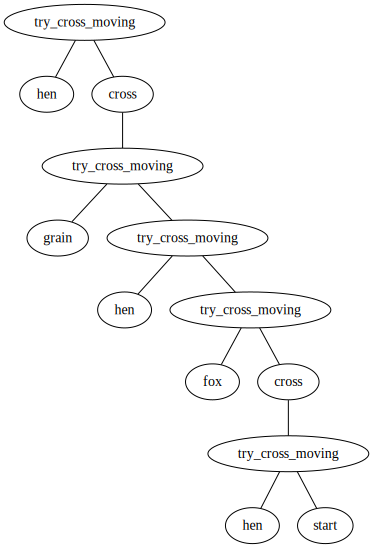

In [6]:
node_graph(
    diagnosis.minimal_reproductions[
        repr(AssertionError('Problem solved'))
    ]
)